# Genetic Algorithm for Feature Selection

A Genetic Algorithm for feature selection is an evolutionary approach inspired by natural selection for selecting optimal feature subsets. The steps involve:

1. Initialization: Generate an initial population of random feature subsets.
2. Evaluation: Train a model using each feature subset and evaluate its performance 
3. Selection: Choose the best-performing feature subsets as parents for the next generation.
4. Crossover: Combine pairs of parent feature subsets to create offspring by mixing their features.
5. Mutation: Introduce small random changes to some offspring to maintain diversity and avoid local optima.
6. Replacement: Replace the worst-performing feature subsets in the population with the new offspring.
7. Iteration: Repeat the process until a stopping criterion is met

Genetic Algorithms can capture complex, non-linear relationships between features, can be used with any type of model, and perform a comprehensive search of the feature space. The script is adapted from the tutorial found here https://medium.com/@ela.markovic/feature-selection-using-genetic-algorithm-complete-beginner-friendly-guide-198496393728 


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import ttest_rel
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.utils.multiclass import unique_labels

import random
from tqdm import tqdm
import os
import glob

### Hyperparameters

In [2]:
# Minimum number of features an individual (a molecule) can have
min_features = 10 
# Maximum number of features an individual (a molecule) can have
max_features = 100 

# The number of individuals in the population. This determines how many candidate solutions
# (feature subsets) are considered in each generation.
population_size = 100 

max_iterations = 50 # Maximum number of generations

# The percentage of the population that will be preserved as elite. Elite individuals
# are kept without change and passed directly to the next generation.
elite_percent = 0.6 

# The probability that a mutation will occur in an individual. Mutation introduces variability
# by flipping feature selections (0 to 1 or 1 to 0) within the individual.
mutation_probability = 0.05 # Probability of mutation

patience = 10  # For early stopping
reevaluation_interval = 10  # Re-evaluate elites every 10 generations

model_types = ['svm', 'random_forest', 'xgboost'] # List of model types to iterate over
problem_types = ['classification','regression']

## Functions to use

### Create an initial population (step 1)

In [3]:
# Function to generate random individuals (feature subsets)
def generate_random_individuals(population_size, num_features, min_features, max_features):
    """
    Generate a population of random individuals represented as binary vectors.

    Parameters:
    population_size (int): Number of individuals in the population.
    num_features (int): Total number of features available.
    min_features (int): Minimum number of features to include in an individual.
    max_features (int): Maximum number of features to include in an individual.

    Returns:
    np.ndarray: A 2D array where each row is a binary vector representing an individual.
    """
    # Initialize the matrix with zeros. if a feature (column) in a population (row) is selected, it will be changed to 1
    individuals = np.zeros((population_size, num_features)) 
    # Loop over the population (in this case, the compounds) and randomly select a set of features to keep 
    for i in range(population_size):
        # Generate a random number of ones (random number of features to keep), which is between min_features and max_features
        num_ones = np.random.randint(min_features, max_features + 1)
        # Randomly assign the ones to features describing the compounds
        ones_indices = np.random.choice(num_features, num_ones, replace=False) #indices that the ones will be assigned to
        individuals[i, ones_indices] = 1 #assign the ones at the indices
    return individuals

### Train a model on every chromosome from the population and calculate accuracy (steps 2 & 3)

This `train_model` function is designed to train a specified regression model, evaluate its performance using cross-validation, and calculate an average R² score to assess model reliability. It starts by selecting only the predictor features specified by predictor_names from the training and test datasets. Based on the model type provided (`random_forest`, `xgboost`, `linear_regression`, or `svr`), the function initializes a model with built-in regularization to prevent overfitting: it limits tree depth in `RandomForestRegressor`, applies both L1 and L2 regularization terms in `XGBRegressor`, uses Ridge (L2) regularization for linear regression, and sets a regularization parameter `C` for `SVR`.

The function then performs 5-fold cross-validation on the training data, obtaining an average R² score (`avg_cv_r2`) that provides a reliable performance estimate by reducing potential overfitting to any single subset of data. After cross-validation, the model is fit on the full training set and used to predict on the test set, yielding a test R² score (`test_r2`). Finally, an overall performance score (`final_score`) is calculated by averaging the cross-validation and test R² scores, giving a balanced measure of how well the model generalizes to new data.

In [4]:
def train_model(x_train, x_val_split, y_train, y_val_split, predictor_names, model_type, problem_type):
    """
    Train a specified model and calculate both loss and accuracy.

    Parameters:
    ----------
    x_train : pd.DataFrame
        Training feature set.
    x_val_split : pd.DataFrame
        Validation feature set.
    y_train : pd.Series
        Training target values.
    y_val_split : pd.Series
        Validation target values.
    predictor_names : list
        List of feature names to include in the model.
    model_type : str
        The type of model ('random_forest', 'xgboost', 'svm').
    problem_type : str
        The problem type ('regression' or 'classification').

    Returns:
    -------
    tuple[float, float]
        Loss and accuracy scores.
    """
    # Define model initialization dictionary
    models = {
        "random_forest": RandomForestClassifier(random_state=42) if problem_type == "classification" else RandomForestRegressor(random_state=42),
        "svm": SVC(probability=True, random_state=42) if problem_type == "classification" else SVR(),
        "xgboost": XGBClassifier(random_state=42) if problem_type == "classification" else XGBRegressor(random_state=42),
    }

    if model_type not in models:
        raise ValueError("Invalid model_type. Choose from 'random_forest', 'xgboost', or 'svm'.")

    # Train model
    mdl = models[model_type]
    mdl.fit(x_train, y_train)
    y_val_pred = mdl.predict(x_val_split)

    if problem_type == "classification":
        y_val_proba = mdl.predict_proba(x_val_split) if hasattr(mdl, "predict_proba") else None
        all_labels = unique_labels(y_train, y_val_split)
        
        # Calculate loss and accuracy
        loss = log_loss(y_val_split, y_val_proba, labels=all_labels) if y_val_proba is not None else 1 - accuracy_score(y_val_split, y_val_pred)
        accuracy = accuracy_score(y_val_split, y_val_pred)

    else:  # Regression
        loss = mean_squared_error(y_val_split, y_val_pred)
        accuracy = r2_score(y_val_split, y_val_pred)

    return loss, accuracy

In [5]:
def calculate_fitness(loss, acc, features_selected, total_features, alpha = 1.0, beta = 1.0, gamma = 0.004):
    """
    Calculate the fitness of an individual based on loss, accuracy, and feature sparsity.

    Parameters:
    ----------
    loss : float
        Validation loss of the model (must be > 0).
    acc : float
        Validation accuracy of the model (range: 0-1).
    features_selected : int
        Number of features selected by the individual.
    total_features : int
        Total number of available features.
    alpha : float, optional
        Weight for the loss term (default is 1.0).
    beta : float, optional
        Weight for the accuracy term (default is 1.0).
    gamma : float, optional
        Weight for the sparsity term (default is 0.004).

    Returns:
    -------
    float
        The fitness value of the individual.
    """
    # Validate inputs
    if loss <= 0:
        raise ValueError("Loss must be greater than zero to avoid division by zero.")
    if not (0 <= acc <= 1):
        raise ValueError("Accuracy must be between 0 and 1.")
    if not (0 < features_selected <= total_features):
        raise ValueError("Selected features must be between 1 and total features.")

    # Calculate sparsity
    percent_features_ignored = (1 - features_selected / total_features) * 100

    # Compute the fitness score
    fitness = (
        alpha / loss +            # Minimize loss
        beta * acc +              # Maximize accuracy
        gamma * percent_features_ignored  # Maximize sparsity
    )
    
    return fitness

In [6]:
def cross_validated_fitness(individual, X, y, model_type, problem_type, k = 3, alpha = 1.0, beta = 1.0, gamma = 0.004
):
    """
    Calculate the average fitness of an individual using k-fold cross-validation.

    Parameters:
    ----------
    individual : np.ndarray
        Binary array representing the selected features.
    X : pd.DataFrame
        Feature dataset.
    y : pd.Series
        Target values.
    model_type : str
        Type of model ('random_forest', 'xgboost', 'svm', etc.).
    problem_type : str
        'regression' or 'classification'.
    k : int, optional
        Number of folds for cross-validation (default is 3).
    alpha, beta, gamma : float, optional
        Weights for loss, accuracy, and sparsity (defaults are 1.0, 1.0, and 0.004).

    Returns:
    -------
    float
        Average fitness score across all folds. Returns -inf if no features are selected.
    """

    kf = KFold(n_splits=k, shuffle=True)
    scores = []

    predictor_names = X.columns[individual == 1]
    num_features_selected = len(predictor_names)

    if num_features_selected == 0:
        return -np.inf  # Invalid individual with no features selected

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]

        # Ensure y is always a Pandas Series
        y_train = y.iloc[train_idx] if isinstance(y, pd.Series) else y[train_idx]
        y_val = y.iloc[val_idx] if isinstance(y, pd.Series) else y[val_idx]

        try:
            # Train model and calculate loss/accuracy
            loss, acc = train_model(X_train, X_val, y_train, y_val, predictor_names, model_type, problem_type)

            # Calculate fitness score
            fitness = calculate_fitness(loss, acc, num_features_selected, len(X.columns), alpha, beta, gamma)
            scores.append(fitness)
        except Exception as e:
            print(f"Error during model training: {e}")
            scores.append(-np.inf)

    return np.mean(scores)


### Functions to Prevent Overfitting and Optimize Algorithm

This step ensures that elite individuals (top performers) are periodically validated using new data splits to detect overfitting. If an elite’s fitness drops significantly, it is replaced.

In [7]:
import numpy as np

def reevaluate_elites(
    population: np.ndarray, 
    fitness: np.ndarray, 
    X: pd.DataFrame, 
    y: pd.Series, 
    model_type: str, 
    problem_type: str, 
    k: int = 3
) -> np.ndarray:
    """
    Re-evaluate the fitness of elites using new cross-validation splits.

    Parameters:
    ----------
    population : np.ndarray
        Population of individuals (feature subsets).
    fitness : np.ndarray
        Fitness scores of the population.
    X : pd.DataFrame
        Feature dataset.
    y : pd.Series
        Target values.
    model_type : str
        Model type ('random_forest', 'xgboost', 'svm', etc.).
    problem_type : str
        'regression' or 'classification'.
    k : int, optional
        Number of folds for cross-validation (default is 3).

    Returns:
    -------
    np.ndarray
        Updated fitness scores after re-evaluation.
    """
    for i, individual in enumerate(population):
        try:
            # Recompute fitness for each individual
            fitness[i] = cross_validated_fitness(individual, X, y, model_type, problem_type, k)
        except Exception as e:
            print(f"Error re-evaluating individual {i}: {e}")
            fitness[i] = -np.inf  # Penalize invalid evaluations

    return fitness

Early stopping halts the algorithm if no significant improvement is observed over several generations.

In [8]:
def check_early_stopping(best_fitness, stagnation_counter, patience, tolerance=1e-5):
    """
    Check whether early stopping should be triggered.

    Parameters:
    ----------
    best_fitness : list[float]
        List of best fitness scores across generations.
    stagnation_counter : int
        Current number of stagnant generations.
    patience : int
        Maximum allowed stagnant generations for early stopping.
    tolerance : float, optional
        Minimum improvement required to consider progress (default is 1e-5).

    Returns:
    -------
    bool
        True if early stopping is triggered, False otherwise.
    """
    if len(best_fitness) <= patience:
        return False  # Not enough generations for comparison

    # Check if there has been significant improvement in the last 'patience' generations
    recent_fitness = best_fitness[-patience:]
    if max(recent_fitness) - min(recent_fitness) < tolerance:
        print(f"Early stopping triggered after {len(best_fitness)} generations.")
        return True

    return False


### Select parents (step 4)

This function chooses parents for the next generation using a combination of elite selection (based on accuracy) and a roulette wheel selection strategy to ensure that well-performing individuals have a higher chance of being selected while maintaining diversity.

The first few lines inside the function calculate the number of elite individuals to keep based on `elite_percent`, sort the individuals in the population in descending order of fitness scores using `np.argsort(-accuracy)`, and select the top `elite_num` individuals as the elite population. The calculation `elite_num = int(round(((elite_percent * population.shape[0]) // 2) * 2))` ensures that `elite_num` is always even so that each elite individual has a potential partner for mating. The `elite_population` array contains these elite individuals that will be preserved for the next generation without mutation.

The rest of the parents are picked based on their accuracy scores using a roulette wheel selection strategy. The `accuracy` array holds the R^2 scores for each individual in the population. The process works as follows:
1. The accuracy scores are normalized to create a weight distribution, and cumulative weights are calculated to represent the total fitness distribution.
2. A random number between 0 and the total cumulative weight is generated to simulate the roulette wheel.
3. The function uses `np.searchsorted` to find the index where the random number fits within the cumulative weights. This index corresponds to a selected chromosome, with higher accuracy scores having greater weights and thus a higher probability of selection.

The function returns an array of chosen parents, which includes both the elite individuals and non-elite individuals selected by the roulette wheel method. This approach maintains a balance between retaining the best-performing solutions and introducing diversity for the next generation.


In [9]:
def choose_parents(population: np.ndarray, fitness: np.ndarray, elite_percent: float) -> np.ndarray:
    """
    Select parents for the next generation based on fitness using elitism and roulette selection.

    Parameters:
    ----------
    population : np.ndarray
        Current population of individuals (feature subsets).
    fitness : np.ndarray
        Array of fitness scores for each individual.
    elite_percent : float
        Percentage of top individuals to preserve as elite.

    Returns:
    -------
    np.ndarray
        Selected parents for the next generation.
    """
    pop_size, num_features = population.shape

    # Ensure elite_num is even for balanced crossover
    elite_num = max(2, int(round((elite_percent * pop_size) // 2) * 2))

    # Rank individuals by descending fitness
    elite_indices = np.argsort(-fitness)[:elite_num]
    elite_population = population[elite_indices]

    # Normalize fitness for roulette wheel selection
    if fitness.sum() == 0:
        raise ValueError("All fitness scores are zero. Check model evaluation or fitness function.")

    # Perform roulette wheel selection
    weight_norm = fitness / fitness.sum()
    weight_cumsum = weight_norm.cumsum()

    # Select non-elite parents
    num_parents_wo_elite = pop_size - elite_num
    parents_wo_elite = np.zeros((num_parents_wo_elite, num_features))

    for i in range(num_parents_wo_elite):
        rand_num = np.random.uniform(0, 1)
        selected_idx = np.searchsorted(weight_cumsum, rand_num)
        parents_wo_elite[i, :] = population[selected_idx, :]

    # Combine elite and selected parents
    parents = np.vstack((elite_population, parents_wo_elite))
    return parents

### Generate children and mutate with probability (step 5 & 6)

The function first calculates the number of elite individuals based on the `elite_percentinput`, and then selects the elite individuals to be directly passed on to the next generation. The remaining children are created using the one-point crossover method, where pairs of parents are selected and a random crossover point is chosen. The children are created by combining the first part of one parent and the second part of the other parent after the crossover point.

After the crossover operation, the function checks if each child has between the minimum number of features and maximum number of features. If the number of 1s (true values) is greater than the maximum allowed number of features, some of the true values are randomly changed to false values. Similarly, if the number of 1s is less than the minimum allowed number of features, some of the false values are randomly changed to true values.

Finally, the function performs mutation by randomly selecting some bits in the child and flipping them from 0 to 1 or from 1 to 0 based on the mutation probability and the number of features already present in the offspring.

The output of the function is a 2D numpy array representing the child population after the one-point crossover and mutation operations.



In [10]:
def one_point_crossover(parents, elite_percent, mutation_probability, min_features, max_features):
    """
    Perform one-point crossover and mutation to generate a new population.

    Parameters:
    ----------
    parents : np.ndarray
        Array of selected parents for crossover.
    elite_percent : float
        Percentage of parents to keep as elite.
    mutation_probability : float
        Probability of mutation occurring in an individual.
    min_features : int
        Minimum number of features an individual can have.
    max_features : int
        Maximum number of features an individual can have.

    Returns:
    -------
    np.ndarray
        New population generated after crossover and mutation.
    """
    pop_size, num_features = parents.shape

    # Ensure elite count is even and calculate elite size
    elite_num = max(2, int(round((elite_percent * pop_size) // 2) * 2))
    new_population = np.zeros_like(parents)
    new_population[:elite_num] = parents[:elite_num]  # Preserve elite individuals

    # Perform one-point crossover
    for i in range(elite_num, pop_size, 2):
        if i + 1 >= pop_size:
            break
        p1, p2 = parents[i], parents[i + 1]
        crossover_point = np.random.randint(1, num_features - 1)

        # Create offspring
        new_population[i] = np.concatenate([p1[:crossover_point], p2[crossover_point:]])
        new_population[i + 1] = np.concatenate([p2[:crossover_point], p1[crossover_point:]])

    # Adjust feature counts
    for ind in range(pop_size):
        feature_count = new_population[ind].sum()

        if feature_count > max_features:
            excess = int(feature_count - max_features)
            indices_to_turn_off = np.random.choice(
                np.where(new_population[ind] == 1)[0], size=excess, replace=False
            )
            new_population[ind, indices_to_turn_off] = 0

        elif feature_count < min_features:
            deficit = min_features - feature_count
            indices_to_turn_on = np.random.choice(
                np.where(new_population[ind] == 0)[0], size=deficit, replace=False
            )
            new_population[ind, indices_to_turn_on] = 1

    # Apply mutations
    num_mutations = int(new_population.size * mutation_probability)
    for _ in range(num_mutations):
        ind_row = np.random.randint(0, pop_size)
        ind_col = np.random.randint(0, num_features)
        current_value = new_population[ind_row, ind_col]

        # Toggle feature with constraint checks
        if current_value == 0 and new_population[ind_row].sum() < max_features:
            new_population[ind_row, ind_col] = 1
        elif current_value == 1 and new_population[ind_row].sum() > min_features:
            new_population[ind_row, ind_col] = 0

    return new_population


## Add Dummy Variable and Save to csv File

In [11]:
def process_and_save_all_files(input_dir, output_dir, selected_columns, descriptor_file, model_type, problem_type):
    """
    Process input files by merging, selecting features, and saving processed files.

    Parameters:
    ----------
    input_dir : str
        Directory containing input CSV files.
    output_dir : str
        Directory to save processed CSV files.
    selected_columns : list
        List of reduced feature names to retain.
    descriptor_file : str
        Path to descriptors_all.csv for reference.
    model_type : str
        Model type used for feature selection (e.g., 'linear_regression').
    problem_type : str
        Either 'regression' or 'classification'.

    Returns:
    -------
    None
    """
    os.makedirs(output_dir, exist_ok=True)
    descriptor_df = pd.read_csv(descriptor_file)
    file_pattern = "*_reg*.csv" if problem_type == "regression" else "*_class*.csv"
    files = glob.glob(os.path.join(input_dir, file_pattern))

    for file_path in files:
        input_df = pd.read_csv(file_path).set_index("Molecule ChEMBL ID")

        if problem_type == "regression":
            merged_df = pd.merge(
                descriptor_df[["Molecule ChEMBL ID", "-logIC50"]],
                input_df,
                on="Molecule ChEMBL ID",
                how="inner"
            )
            # Add dummy variable
            if "-logIC50" in merged_df.columns:
                merged_df['is_imputed'] = np.isclose(
                    merged_df['-logIC50'], -np.log(10000 * 1e-9), atol=1e-6
                ).astype(int)
                processed_df = merged_df.loc[:, selected_columns + ['is_imputed']]
                processed_df.drop(columns="-logIC50", inplace=True, errors="ignore")
            else:
                processed_df = merged_df[selected_columns]
        else:  # Classification
            processed_df = input_df[selected_columns]

        if not processed_df.empty:
            output_path = os.path.join(output_dir, os.path.basename(file_path))
            processed_df.to_csv(output_path, index=True)

## Read inputs and run 

Progress for svm:  35%|████████▎               | 17/49 [12:43<23:57, 44.93s/gen]

Early stopping triggered due to stagnation.


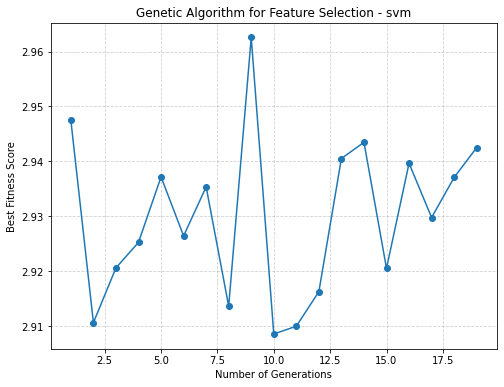

Progress for svm:  18%|████▌                    | 9/49 [02:45<12:16, 18.41s/gen]

Early stopping triggered due to stagnation.


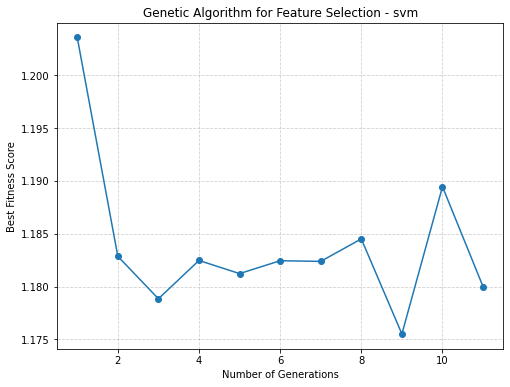

Progress for random_forest:  18%|██▊            | 9/49 [12:41<56:25, 84.65s/gen]

Early stopping triggered due to stagnation.


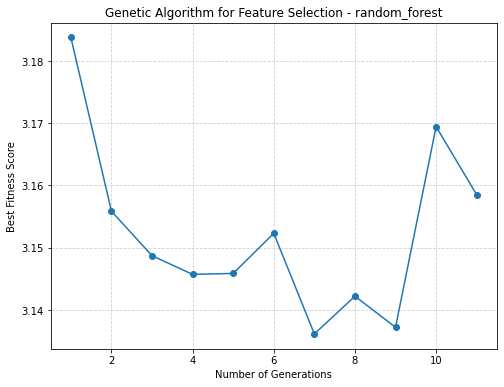

Progress for random_forest:  18%|█▍      | 9/49 [5:20:15<23:43:21, 2135.03s/gen]

Early stopping triggered due to stagnation.


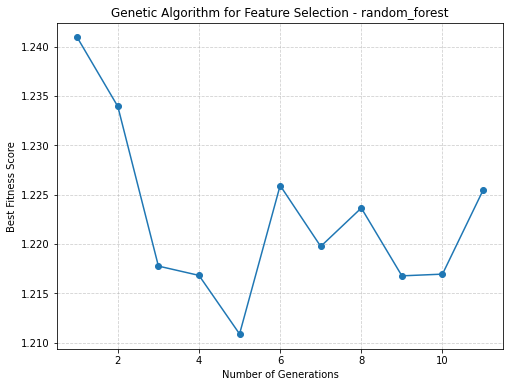

Progress for xgboost:  31%|████▌          | 15/49 [3:05:32<7:00:33, 742.15s/gen]

Early stopping triggered due to stagnation.


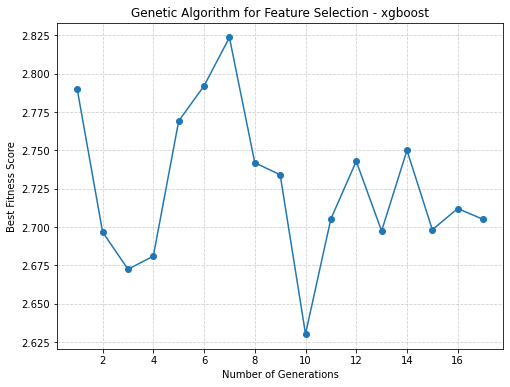

Progress for xgboost:  18%|██▉             | 9/49 [1:56:38<8:38:23, 777.59s/gen]

Early stopping triggered due to stagnation.


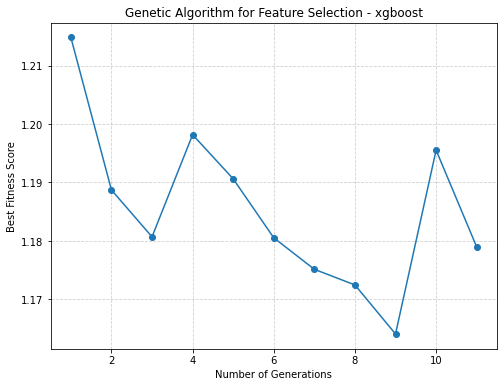

In [12]:
# Initialize label encoder
label_encoder = None  

for model_type in model_types:
    for problem_type in problem_types:
        # Load dataset
        data_file = (
            "../../3_train_test_split/train_reg.csv" if problem_type == "regression" 
            else "../../3_train_test_split/train_class.csv"
        )
        
        try:
            # Load features and target values
            data = pd.read_csv(data_file).set_index("Molecule ChEMBL ID")
            y = pd.read_csv("../../3_train_test_split/descriptors_all.csv").set_index("Molecule ChEMBL ID")
            
            target_column = "-logIC50" if problem_type == "regression" else "Potency"
            merged = pd.merge(data, y[[target_column]], left_index=True, right_index=True, how="inner")
            X, y = merged.drop(columns=target_column), merged[target_column]

            # Encode target labels for classification
            if problem_type == "classification":
                label_encoder = LabelEncoder()
                y = label_encoder.fit_transform(y.str.strip())

        except FileNotFoundError as e:
            print(f"File not found: {e}")
            continue

        # Initialize genetic algorithm variables
        num_features = X.shape[1]
        population = generate_random_individuals(population_size, num_features, min_features, max_features)
        fitness = np.zeros(population_size)
        predictor_names = X.columns
        stagnation_counter = 0
        best_fitness_i = np.zeros(max_iterations)
        best_fitness_overall = -np.inf

        # Evaluate Initial Population
        fitness = np.array([
            cross_validated_fitness(ind, X, y, model_type, problem_type, k=3)
            for ind in population
        ])
        
        best_fitness_i[0] = fitness.max()
        best_fitness_overall = fitness.max()

        # Run Genetic Algorithm
        with tqdm(total=max_iterations - 1, desc=f'Progress for {model_type}', unit='gen') as pbar:
            for gen in range(1, max_iterations):
                # Select parents and generate offspring
                parents = choose_parents(population, fitness, elite_percent)
                children = one_point_crossover(
                    parents, elite_percent, mutation_probability, min_features, max_features
                )
                population = children

                # Evaluate new population
                fitness = np.array([
                    cross_validated_fitness(ind, X, y, model_type, problem_type, k=3)
                    for ind in population
                ])
                
                best_fitness_i[gen] = fitness.max()
                if fitness.max() > best_fitness_overall:
                    best_fitness_overall = fitness.max()
                    stagnation_counter = 0
                else:
                    stagnation_counter += 1

                if stagnation_counter >= patience:
                    print("Early stopping triggered due to stagnation.")
                    break

                pbar.update(1)

        # Save Best Model and Results
        best_individual_idx = fitness.argmax()
        best_features = population[best_individual_idx]
        best_feature_names = predictor_names[best_features == 1]

        process_and_save_all_files(
            ".", model_type, best_feature_names, 
            "../../3_train_test_split/descriptors_all.csv", 
            model_type, problem_type
        )

        # Save and Plot Results
        os.makedirs("plots", exist_ok=True)
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, gen + 2), best_fitness_i[:gen + 1], marker='o')
        plt.xlabel("Number of Generations")
        plt.ylabel("Best Fitness Score")
        plt.title(f"Genetic Algorithm for Feature Selection - {model_type}")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.savefig(f'plots/genetic_algorithm_plot_{model_type}_{problem_type}.png', dpi=150)
        plt.show()